In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## 是用Colab跑的

In [ ]:
import time
import numpy as np
import pandas as pd
import pickle
#import pickle5 as pickle
import copy
import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split


In [ ]:
import lightgbm as lgb

In [ ]:
with open('/content/drive/MyDrive/imb.pickle','rb') as handle:
    imb = pickle.load(handle)

In [ ]:
from sklearn.metrics import confusion_matrix


def opt_score(y_true, y_predict):
    def specificity_score(y_true, y_predict):
        conf = confusion_matrix(y_true=y_true, y_pred=y_predict)
        return conf[0,0]/(conf[0,0]+conf[0, 1])
    target1_pro = 0.919271
    target0_pro = 1 - target1_pro 
    opt_score = specificity_score(y_true, y_predict)*target1_pro*0.03 - (1-recall_score(y_true, y_predict))*target0_pro
    return (opt_score+0.1)*5

In [ ]:
def opt_score2(y_true, y_predict, x_train):
    import numpy as np
    pos_index = (y_predict > 0.5).nonzero()
    neg_index = (y_predict < 0.5).nonzero()
    true_index = (y_true == 1).nonzero()
    false_index = (y_true == 0).nonzero()
    
    # specificity 
    s_index = np.intersect1d(neg_index, false_index)
    s_loss = x_train[s_index,3].sum() # annuty
    # (1-recall)
    invr_index = np.intersect1d(neg_index, true_index)
    invr_loss = x_train[invr_index, 2].sum() # credict
    
    return (s_loss - invr_loss)/x_train.shape[0]

# Tuning with opt_score2
- two stage tuning :  
  **pros** : saving time  
  **cons** : too greedy to reach the real maximum  
  It will be better to tuning all 4 variables together, but it is really time consuming, so i split the tuning process into two phase :
  - phase I :  
  tuning learning rates and max depth of decision tree
  - pahse II :  
  tuning bagging fraction(fixed bagging frequency as 10) tree and number of leaves

In [ ]:
lgb_DT = dict()

In [ ]:
learning_rates = [0.05,0.075,0.1,0.15]
max_depths = [6,10,13,15,20]
bagging_fractions = [0.7,0.8,0.85,0.9,0.95]
num_leavess = [15,18,20,25]
n_iters = [200,400,500,600,700]

In [ ]:
best_l = 0
best_d = 0
best_opt = 0

# tuning learnign rate and  max depth

In [ ]:
# n 200
for l in learning_rates:
    for d in max_depths:
        tStart = time.time()
        # --------------------------------------------------------- #
        # train
        lgbc = lgb.LGBMClassifier(booster='gbdt',
                                  nthread=-1,
                                  max_depth = d,
                                  learning_rate=l,
                                  n_estimators=200,
                                  objective='binary',
                                  lambda_l1=0.6,
                                  lambda_l2=0,
                                  is_unbalance = True,
                                  seed=46)
        lgbc.fit(imb["X_subtrain"],imb["y_subtrain"])
        lgb_DT[str(l)+'@'+str(d)] = lgbc
        # valid
        ypred = lgbc.predict(imb["X_valid"])
        opt = opt_score2(imb["y_valid"],ypred,imb["X_valid"])
        if opt > best_opt:
            print("! update best !")
            best_l = l
            best_d = d
            best_opt = opt
        # --------------------------------------------------------- #
        tEnd = time.time()
        print("l: %f, d: %d, opt: %f, spend %f sec\n"%(l,d,opt,tEnd-tStart))
print("best l: %f, best d: %d, opt: %f"%(best_l,best_d,best_opt))

! update best !
l: 0.050000, d: 6, opt: 960.414188, spend 11.447185 sec

l: 0.050000, d: 10, opt: 912.683815, spend 12.088823 sec

l: 0.050000, d: 13, opt: 944.939300, spend 12.256882 sec

l: 0.050000, d: 15, opt: 921.682904, spend 12.231836 sec

! update best !
l: 0.050000, d: 20, opt: 997.104504, spend 12.189103 sec

l: 0.075000, d: 6, opt: 798.760517, spend 10.722943 sec

l: 0.075000, d: 10, opt: 835.407973, spend 10.856297 sec

l: 0.075000, d: 13, opt: 741.737179, spend 10.962636 sec

l: 0.075000, d: 15, opt: 823.662869, spend 10.850435 sec

l: 0.075000, d: 20, opt: 693.810845, spend 10.908130 sec

l: 0.100000, d: 6, opt: 570.939058, spend 10.306366 sec

l: 0.100000, d: 10, opt: 607.771906, spend 10.234757 sec

l: 0.100000, d: 13, opt: 623.221364, spend 10.124441 sec

l: 0.100000, d: 15, opt: 567.395478, spend 10.021474 sec

l: 0.100000, d: 20, opt: 768.079349, spend 10.039423 sec

l: 0.150000, d: 6, opt: 191.569969, spend 9.864333 sec

l: 0.150000, d: 10, opt: -27.189639, spend 9.

In [ ]:
best_b = 0
best_n = 0
best_opt = 0

# fixed bagging_freq tuning bagging_fraction and num_leaves

In [ ]:
# 
for b in bagging_fractions:
    for n in num_leavess:
        tStart = time.time()
        # --------------------------------------------------------- #
        # train
        lgbc = lgb.LGBMClassifier(booster='gbdt',
                                  nthread=-1,
                                  max_depth = 20,
                                  learning_rate=0.05,
                                  n_estimators=200,
                                  objective='binary',
                                  lambda_l1=0.6,
                                  lambda_l2=0,
                                  is_unbalance = True,
                                  num_leaves = n,
                                  bagging_fraction =b,
                                  bagging_freq = 10,
                                  seed=46)
        lgbc.fit(imb["X_subtrain"],imb["y_subtrain"])
        lgb_DT[str(b)+'$'+str(n)] = lgbc
        # valid
        ypred = lgbc.predict(imb["X_valid"])
        opt = opt_score2(imb["y_valid"],ypred,imb["X_valid"])
        if opt > best_opt:
            print("! update best !")
            best_b = b
            best_n = n
            best_opt = opt
        # --------------------------------------------------------- #
        tEnd = time.time()
        print("b: %f, n: %d, opt: %f, spend %f sec\n"%(b,n,opt,tEnd-tStart))
print("best b: %f, best :n %d, opt: %f"%(best_b,best_n,best_opt))

! update best !
b: 0.700000, n: 15, opt: 1362.894799, spend 10.777616 sec

! update best !
b: 0.700000, n: 18, opt: 1499.889329, spend 11.080922 sec

b: 0.700000, n: 20, opt: 1413.051296, spend 11.230476 sec

b: 0.700000, n: 25, opt: 1285.150616, spend 11.646568 sec

b: 0.800000, n: 15, opt: 1032.348889, spend 11.364837 sec

b: 0.800000, n: 18, opt: 1217.003680, spend 11.840153 sec

b: 0.800000, n: 20, opt: 1236.823647, spend 11.957847 sec

b: 0.800000, n: 25, opt: 1309.889495, spend 12.342117 sec

b: 0.850000, n: 15, opt: 1280.988490, spend 11.927841 sec

b: 0.850000, n: 18, opt: 1117.960690, spend 12.400296 sec

b: 0.850000, n: 20, opt: 1178.512258, spend 12.689719 sec

b: 0.850000, n: 25, opt: 1251.712670, spend 12.957372 sec

b: 0.900000, n: 15, opt: 1269.678460, spend 12.481797 sec

b: 0.900000, n: 18, opt: 1240.844315, spend 12.844381 sec

b: 0.900000, n: 20, opt: 1177.503319, spend 12.945545 sec

b: 0.900000, n: 25, opt: 1196.674009, spend 13.627297 sec

b: 0.950000, n: 15, opt:

In [ ]:
X_train = np.vstack((imb["X_subtrain"],imb["X_valid"]))
y_train = np.vstack((imb["y_subtrain"].reshape(-1,1),imb["y_valid"].reshape(-1,1))).reshape(imb["y_subtrain"].shape[0]+imb["y_valid"].shape[0],)

# fit best model

In [ ]:
lgbc = lgb.LGBMClassifier(booster='gbdt',
                                  nthread=-1,
                                  max_depth = 20,
                                  learning_rate=0.05,
                                  n_estimators=200,
                                  objective='binary',
                                  lambda_l1=0.6,
                                  lambda_l2=0,
                                  is_unbalance = True,
                                  num_leaves = 18,
                                  bagging_fraction =0.7,
                                  bagging_freq = 10,
                                  seed=46)

lgbc.fit(X_train,y_train)

LGBMClassifier(bagging_fraction=0.7, bagging_freq=10, booster='gbdt',
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', is_unbalance=True, lambda_l1=0.6,
               lambda_l2=0, learning_rate=0.05, max_depth=20,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, nthread=-1, num_leaves=18,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, seed=46, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [ ]:
ypredt = lgbc.predict_proba(imb["X_test"])[:,1] > 0.5
test_opt = opt_score2(imb["y_test"],ypredt,imb["X_test"])
print("test_opt: %f"%(test_opt))

test_opt: 2316.351733


In [ ]:
import pandas as pd
import copy
df1 = pd.read_csv('/content/drive/MyDrive/preprocessed.csv')
col_name = list(df1.columns)
print(col_name)
col_name=col_name[3:]
print(col_name)

['Unnamed: 0', 'SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLA

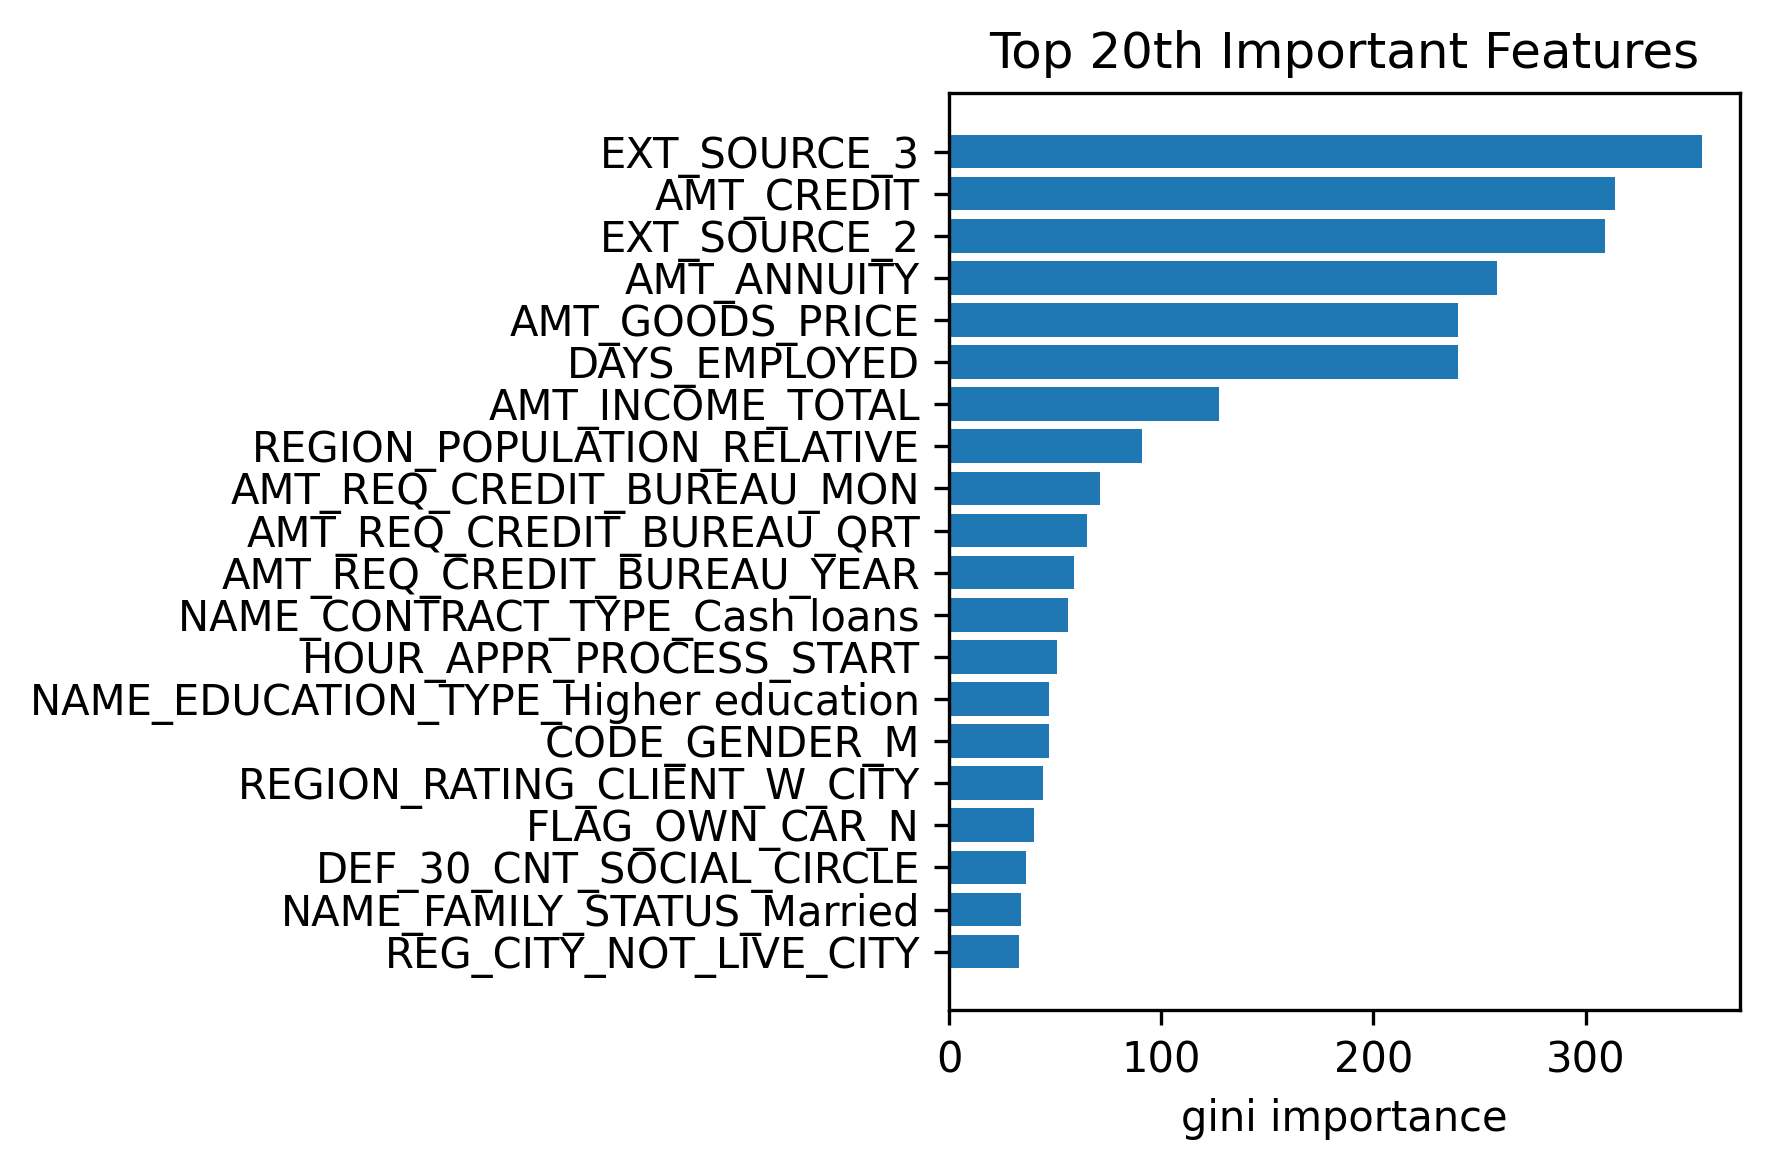

In [ ]:

importances = lgbc.feature_importances_

indices = np.argsort(importances)#[::-1]


labels = []
gini_im = []
for i in indices[-20:]:
    labels.append(col_name[i])
    gini_im.append(importances[i])
    
#plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 改字體，標題才可以是中文
plt.rcParams['figure.dpi'] = 300
plt.barh(labels, gini_im,)
plt.xlabel('gini importance')
plt.title('Top 20th Important Features')
plt.tight_layout()
plt.savefig('important_features_lgbc.png', transparent = True)
plt.show()

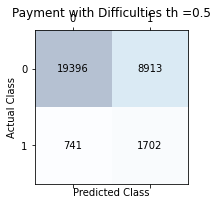

accuracy = 0.6860691987513007
f1_score = 0.26068310614182877
precision = 0.16033914272256242
recall = 0.6966844044207942
opt_score = 0.47204438707628704
opt_score2 = 2316.3517332206034


In [ ]:
plt_title = 'Payment with Difficulties th =0.5'
confmat = confusion_matrix(y_true=imb["y_test"], y_pred=ypredt)
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xticks([0, 1], [0, 1])
plt.yticks([0, 1], [0, 1])
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title(plt_title)
plt.tight_layout()
plt.savefig('lgb_L005_N200_NL18_D20_BF07.png', transparent = True)
plt.show()

acc = accuracy_score(imb["y_test"],ypredt)
f1 = f1_score(imb["y_test"], ypredt)
precision = precision_score(imb["y_test"], ypredt)
recall = recall_score(imb["y_test"], ypredt)
opt = opt_score(imb["y_test"], ypredt)
opt2 = opt_score2(imb["y_test"], ypredt,imb["X_test"])
print('accuracy =', acc)
print('f1_score =', f1)
print('precision =', precision)
print('recall =', recall)
print('opt_score =', opt)
print('opt_score2 =', opt2)